In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import pickle
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from dataloader.builder import build_dataset
from model.mlp import MLP
from model.ensemble import MLPEnsemble
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS
from experiment_setup import build_estimator
from analysis.metrics import get_uq_metrics
from experiments.utils.data import scale, split_ood, multiple_kfold
import torch

plt.rcParams['figure.facecolor'] = 'white'
torch.cuda.set_device(1)

In [3]:
config = {
    'nn_runs': 100,
    'runs': 2,
    'max_runs': 20,
    'k_folds': 10,
    'verbose': False,
    'layers': [8, 256, 256, 128, 1],
    'epochs': 10_000,
    'validation_step': 100,
    'acc_percentile': 0.1,
    'patience': 3,
    'dropout_rate': 0.2,
    'dropout_uq': 0.5,
    'batch_size': 256,
    'dataset': 'kin8nm',
    'l2_reg': 1e-4,
    'ood_percentile': 90,
    'with_ensembles': True
}

In [4]:
train_opts = ['patience', 'dropout_rate', 'epochs', 'batch_size', 'validation_step']
config['train_opts'] = {k: config[k] for k in config if k in train_opts}


### Get data

In [7]:
dataset = build_dataset(config['dataset'], val_split=0.01) 
x_all, y_all = dataset.dataset('train')
x_set, y_set, x_ood, y_ood = split_ood(x_all, y_all, config['ood_percentile'])
config['layers'][0] = x_all.shape[-1]

### Defining support functions


In [13]:
masks = build_masks(DEFAULT_MASKS)

def construct_estimator(model, model_type, name):
    if model_type == 'mask': 
        mask = masks[name]
        return build_estimator(
            'mcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])
    elif model_type == 'emask': 
        mask = masks[name]
        return build_estimator(
            'emcdue_masked', model, nn_runs=config['nn_runs'], dropout_mask=mask,
            dropout_rate=config['dropout_uq'])
    else:
        return build_estimator(name, model)


class Evaluator:    
    def __init__(self, x_test, y_test, y_scaler, tag='standard'):
        self.x_test = x_test
        self.y_test = y_test
        self.unscale = lambda y : y_scaler.inverse_transform(y) 
        self.tag = tag
        self.results = []

    def bench(self, model, name, model_type='mask'): 
        predictions = model(self.x_test).cpu().numpy()
        
        errors = np.abs(predictions - self.y_test)
        
        scaled_errors = self.unscale(predictions) - self.unscale(self.y_test)
        rmse = np.sqrt(np.mean(np.square(scaled_errors)))

        estimator = construct_estimator(model, model_type, name)
        if model_type == 'emask':
            name = 'e_' + name
        
        for run in range(config['runs']):
            estimations = estimator.estimate(self.x_test)
            acc, ndcg, ll = get_uq_metrics(estimations, errors, config['acc_percentile'])
            self.results.append([acc, ndcg, ll, rmse, name, self.tag])
            if hasattr(estimator, 'reset'):
                estimator.reset()
            


### Train and generate results

In [ ]:
mask_results = [] 
kfold_iterator = multiple_kfold(config['k_folds'], len(x_set), config['max_runs'])

for m, (train_idx, val_idx) in enumerate(kfold_iterator):
    x_train, y_train = x_set[train_idx], y_set[train_idx]
    x_val, y_val = x_set[val_idx], y_set[val_idx]
    print("Iteration", m+1)

    x_train, x_val, x_scaler = scale(x_train, x_val)
    y_train, y_val, y_scaler = scale(y_train, y_val)
    x_ood_scaled = x_scaler.transform(x_ood)
    y_ood_scaled = y_scaler.transform(y_ood)
    
    standard_evaluator = Evaluator(x_val, y_val, y_scaler, 'standard')
    ood_evaluator = Evaluator(x_ood_scaled, y_ood_scaled, y_scaler, 'ood')
    
    
    #Dropout 
    optimizer={'type': 'Adadelta', 'weight_decay': config['l2_reg']}
    model = MLP(config['layers'], optimizer=optimizer)
    model.fit((x_train, y_train), (x_val, y_val), **config['train_opts'])
    
    for name in masks: 
        standard_evaluator.bench(model, name, 'mask')
        ood_evaluator.bench(model, name, 'mask')
    
    # RMSE ensemble
    train_opts = config['train_opts'].copy()
    model = MLPEnsemble(config['layers'], n_models=5, reduction='mean')
    model.fit((x_train, y_train), (x_val, y_val), **train_opts)

    standard_evaluator.bench(model, 'eue', 'ensemble')
    ood_evaluator.bench(model, 'eue', 'ensemble')
    
    for name in masks: 
        standard_evaluator.bench(model, name, 'emask')
        ood_evaluator.bench(model, name, 'emask')
    
    mask_results += standard_evaluator.results
    mask_results += ood_evaluator.results
    

Iteration 1
Epoch [100/10000], Loss: 0.0984, Validation loss: 0.1176
Epoch [200/10000], Loss: 0.0749, Validation loss: 0.1351
Epoch [300/10000], Loss: 0.0485, Validation loss: 0.1016
Epoch [400/10000], Loss: 0.0407, Validation loss: 0.1102
Epoch [500/10000], Loss: 0.0386, Validation loss: 0.0939
Epoch [600/10000], Loss: 0.0450, Validation loss: 0.1114
Epoch [700/10000], Loss: 0.0436, Validation loss: 0.1160
Epoch [800/10000], Loss: 0.0640, Validation loss: 0.1207
Fit [1/5] model:
Epoch [100/10000], Loss: 0.1067, Validation loss: 0.0959
Epoch [200/10000], Loss: 0.0580, Validation loss: 0.0971
Epoch [300/10000], Loss: 0.0409, Validation loss: 0.0988
Epoch [400/10000], Loss: 0.0410, Validation loss: 0.1106
Fit [2/5] model:
Epoch [100/10000], Loss: 0.0756, Validation loss: 0.1037
Epoch [200/10000], Loss: 0.0494, Validation loss: 0.0962
Epoch [300/10000], Loss: 0.0413, Validation loss: 0.0944
Epoch [400/10000], Loss: 0.0384, Validation loss: 0.1131
Epoch [500/10000], Loss: 0.0276, Validatio

### Plot the results 

In [11]:
mask_df

,Acc,NDCG,LL,RMSE,Mask,Tag
0,0.164384,0.394932,0.495188,0.074922,vanilla,standard
1,0.178082,0.385776,0.477835,0.074922,vanilla,standard
2,0.191781,0.426136,0.513791,0.074922,mirror_random,standard
3,0.191781,0.400889,0.488412,0.074922,mirror_random,standard
4,0.178082,0.394768,0.312529,0.074922,decorrelating,standard
5,0.150685,0.411321,0.326558,0.074922,decorrelating,standard
6,0.219178,0.401729,-0.267427,0.074922,decorrelating_sc,standard
7,0.232877,0.402261,-0.414538,0.074922,decorrelating_sc,standard
8,0.123288,0.372538,0.555264,0.074922,dpp,standard
9,0.123288,0.367802,0.532018,0.074922,dpp,standard


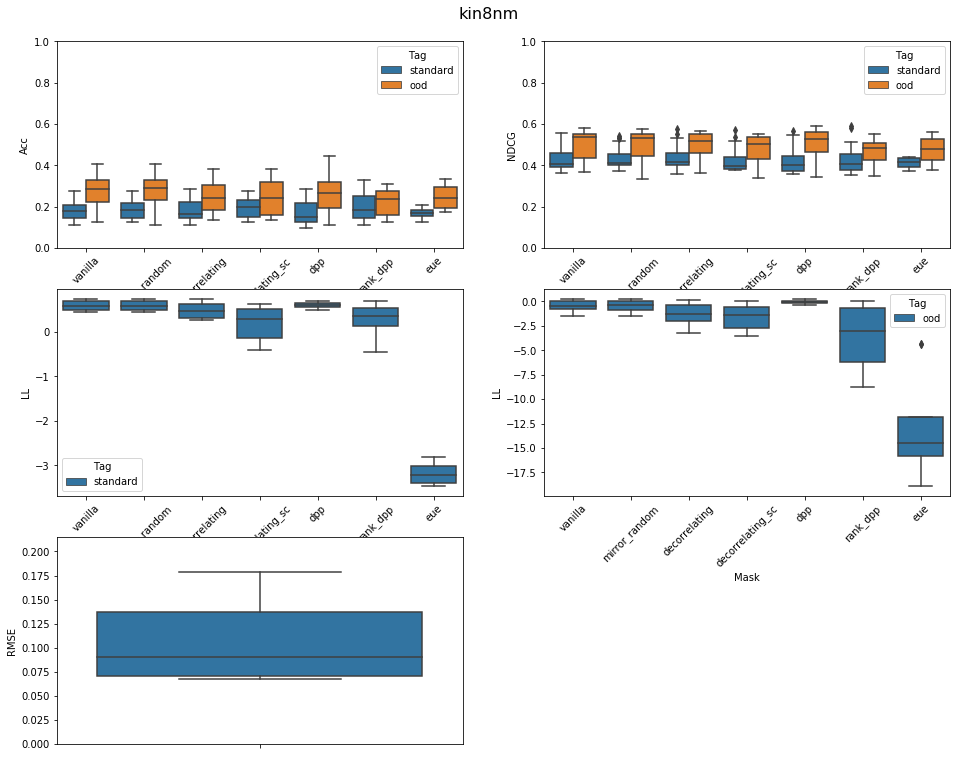

In [10]:
mask_df = pd.DataFrame(mask_results, columns=['Acc', 'NDCG', 'LL', 'RMSE', 'Mask', 'Tag'])

fig = plt.figure(figsize=(16, 16))
plt.suptitle(config['dataset'], fontsize=16)
fig.subplots_adjust(top=0.95)


def boxplot(df, x_label, y_label, i, bottom=0, top=1):
    plt.subplot(4, 2, i)
    plt.xticks(rotation=45)
    if bottom is not None:
        plt.ylim(bottom, top)
    sns.boxplot(data=df, x=x_label, y=y_label, hue='Tag')

boxplot(mask_df, 'Mask', 'Acc', 1, 0, 1)
boxplot(mask_df, 'Mask', 'NDCG', 2, 0, 1)
boxplot(mask_df[mask_df.Tag=='standard'], 'Mask', 'LL', 3, None)
boxplot(mask_df[mask_df.Tag=='ood'], 'Mask', 'LL', 4, None)
boxplot(mask_df, None, 'RMSE', 5, 0, 1.2*mask_df.RMSE.max())


In [ ]:
timestamp = datetime.now().strftime("%y-%m-%d__%H_%M")
with open(f"data/results_{config['dataset']}_{timestamp}.pkl", 'wb') as f:
    pickle.dump(mask_results, f)
    